In [1]:
# Basics
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import missingno as msno
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler

# Sampling
from sklearn.model_selection import train_test_split

# Classifiier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import accuracy_score

%matplotlib inline
sns.set(color_codes=True)
pal = sns.color_palette("Set2", 10)
sns.set_palette(pal)

train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [2]:
#look at what we have for data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# See how much data is missing
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


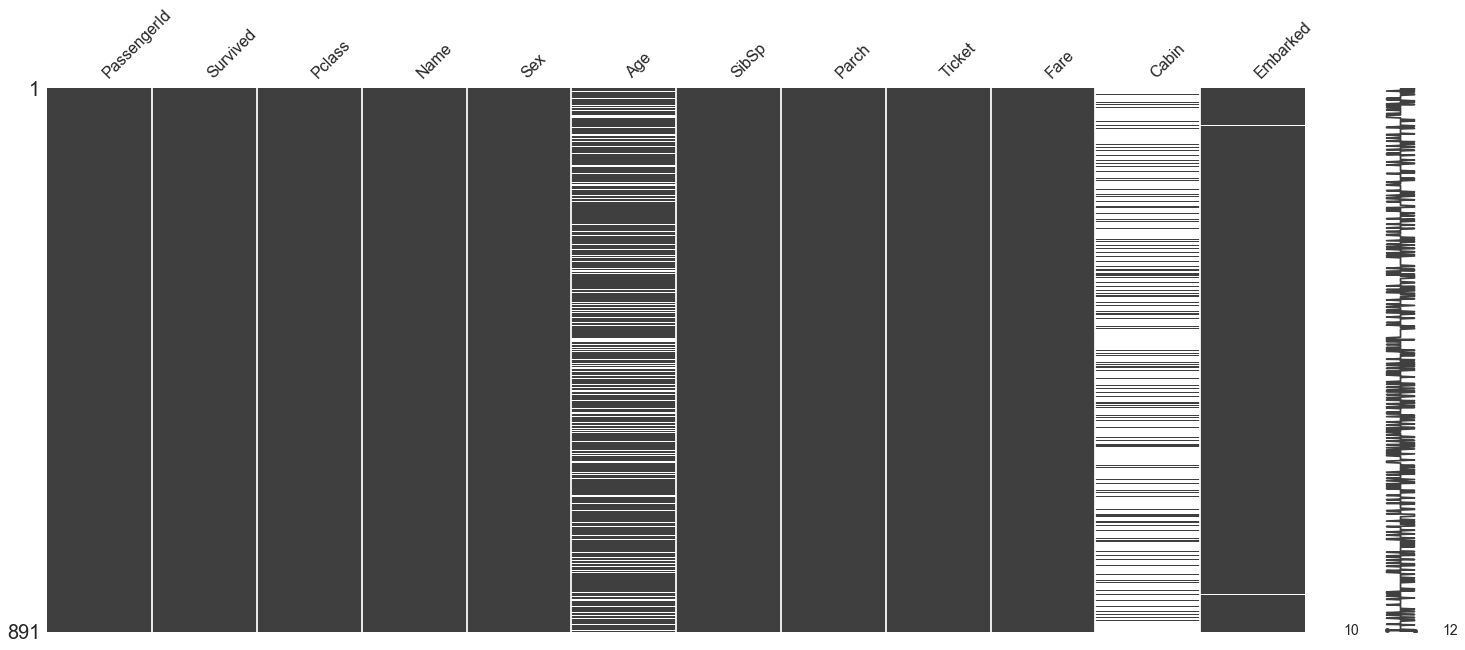

In [4]:
msno.matrix(train_data)

C:\Users\ndbie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\ndbie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


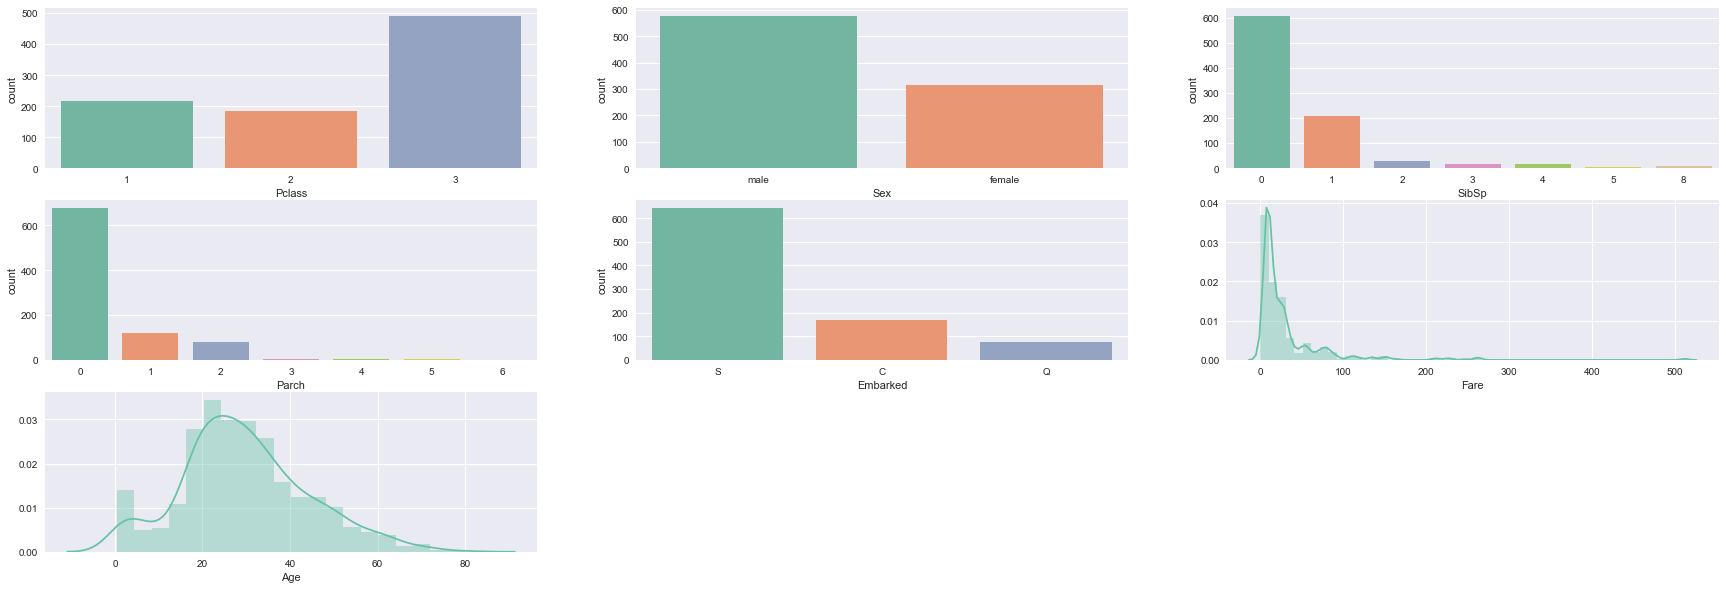

In [5]:
categ =  [ 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
conti = ['Fare', 'Age']

#Distribution
fig = plt.figure(figsize=(30, 10))
for i in range (0,len(categ)):
    fig.add_subplot(3,3,i+1)
    sns.countplot(x=categ[i], data=train_data);  

for col in conti:
    fig.add_subplot(3,3,i + 2)
    sns.distplot(train_data[col].dropna());
    i += 1
    
plt.show()
fig.clear()

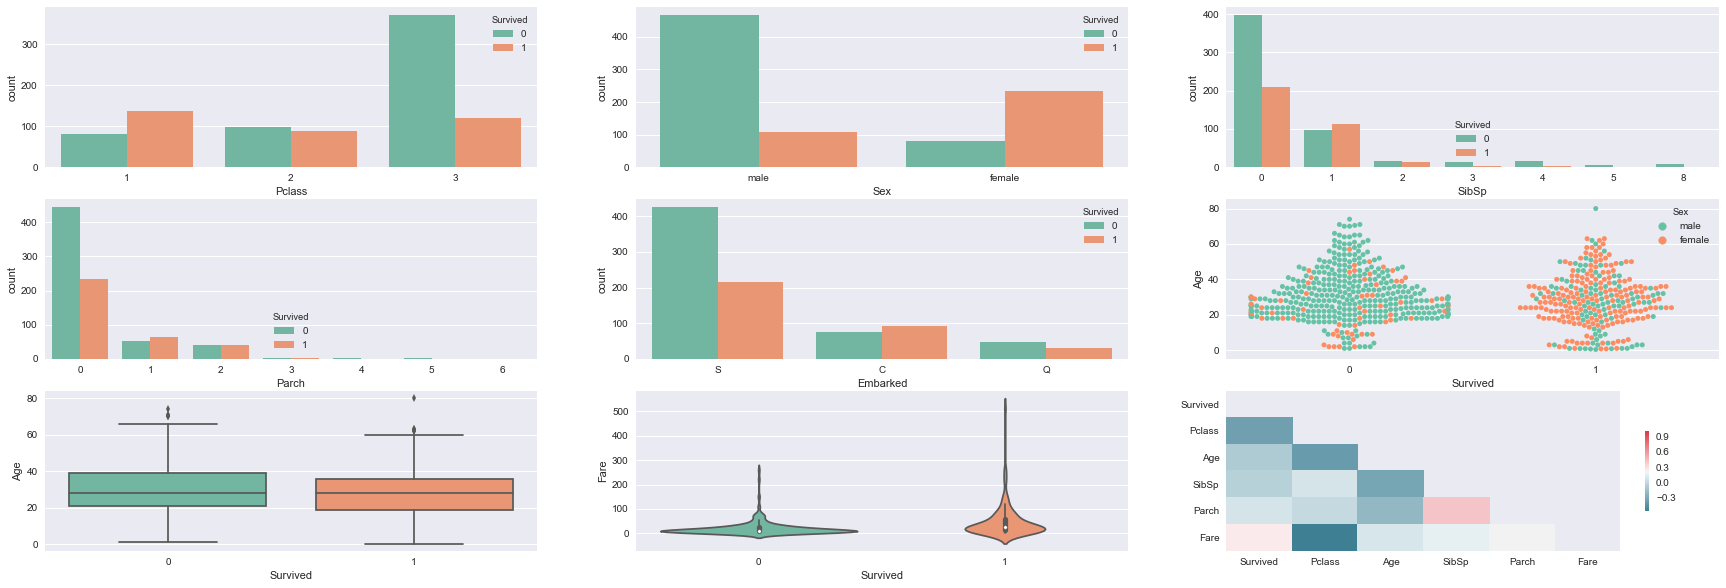

In [6]:
fig = plt.figure(figsize=(30, 10))
i = 1
for col in categ:
    if col != 'Survived':
        fig.add_subplot(3,3,i)
        sns.countplot(x=col, data=train_data,hue='Survived');
        i += 1

# Box plot survived x age
fig.add_subplot(3,3,6)
sns.swarmplot(x="Survived", y="Age", hue="Sex", data=train_data);
fig.add_subplot(3,3,7)
sns.boxplot(x="Survived", y="Age", data=train_data)

# fare and Survived
fig.add_subplot(3,3,8)
sns.violinplot(x="Survived", y="Fare", data=train_data)

# correlations with the new features
corr = train_data.drop(['PassengerId'], axis=1).corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig.add_subplot(3,3,9)
sns.heatmap(corr, mask=mask, cmap=cmap, cbar_kws={"shrink": .5})
plt.show()
fig.clear()

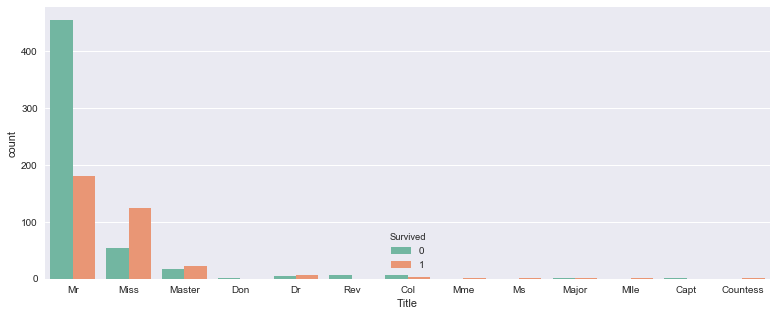

In [7]:
title = ['Mlle','Mrs', 'Mr', 'Miss','Master','Don','Rev','Dr','Mme','Ms','Major','Col','Capt','Countess']

def ExtractTitle(name):
    tit = 'missing'
    for item in title :
        if item in name:
            tit = item
    if tit == 'missing':
        tit = 'Mr'
    return tit

train_data["Title"] = train_data.apply(lambda row: ExtractTitle(row["Name"]),axis=1)
plt.figure(figsize=(13, 5))
fig.add_subplot(2,1,1)
sns.countplot(x='Title', data=train_data,hue='Survived');

In [8]:
# Age
MedianAge = train_data.Age.median()
train_data.Age = train_data.Age.fillna(value=MedianAge)
# Embarked replace NaN with the mode value
ModeEmbarked = train_data.Embarked.mode()[0]
train_data.Embarked = train_data.Embarked.fillna(value=ModeEmbarked)
# Fare have 1 NaN missing value on the Submission dataset
MedianFare = train_data.Fare.median()
train_data.Fare = train_data.Fare.fillna(value=MedianFare)

In [9]:
# Cabin
train_data["Cabin"] = train_data.apply(lambda obs: "No" if pd.isnull(obs['Cabin']) else "Yes", axis=1)
train_data = pd.get_dummies(train_data,drop_first=True,columns=['Sex','Title','Cabin','Embarked'])

In [10]:
scale = StandardScaler().fit(train_data[['Age', 'Fare']])
train_data[['Age', 'Fare']] = scale.transform(train_data[['Age', 'Fare']])

In [11]:
Target = train_data.Survived
Features = train_data.drop(['Survived','Name','Ticket','PassengerId'],axis=1)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size = 0.3, random_state=42)
Target = train_data.Survived

MlRes= {}
def MlResult(model,score):
    MlRes[model] = score
    print(MlRes)
    
roc_curve_data = {}
def ConcatRocData(algoname, fpr, tpr, auc):
    data = [fpr, tpr, auc]
    roc_curve_data[algoname] = data  

In [12]:
# Logistic Regression : 
logi_reg = LogisticRegression()
# Fit the regressor to the training data
logi_reg.fit(X_train, y_train)
# Predict on the test data: y_pred
y_pred = logi_reg.predict(X_test)

# Score / Metrics
accuracy = logi_reg.score(X_test, y_test)
MlResult('Logistic Regression',accuracy)

{'Logistic Regression': 0.8283582089552238}


In [13]:
# Create a random Forest Classifier instance
rfc = RandomForestClassifier(n_estimators = 100)
# Fit to the training data
rfc.fit(X_train, y_train)
# Predict on the test data: y_pred
y_pred = rfc.predict(X_test)

# Score / Metrics
accuracy = rfc.score(X_test, y_test) # = accuracy
MlResult('Random Forest',accuracy)

{'Logistic Regression': 0.8283582089552238, 'Random Forest': 0.7910447761194029}


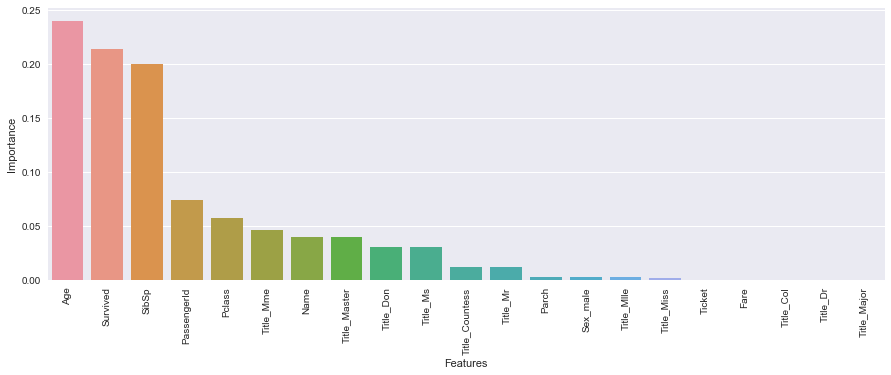

In [14]:
#Features importance
def FeaturesImportance(data,model):
    features = data.columns.tolist()
    fi = model.feature_importances_
    sorted_features = {}
    for feature, imp in zip(features, fi):
        sorted_features[feature] = round(imp,3)

    # sort the dictionnary by value
    sorted_features = OrderedDict(sorted(sorted_features.items(),reverse=True, key=lambda t: t[1]))

    #for feature, imp in sorted_features.items():
        #print(feature+" : ",imp)

    dfvi = pd.DataFrame(list(sorted_features.items()), columns=['Features', 'Importance'])
    #dfvi.head()
    plt.figure(figsize=(15, 5))
    sns.barplot(x='Features', y='Importance', data=dfvi);
    plt.xticks(rotation=90) 
    plt.show()
    
#Features importance
FeaturesImportance(train_data,rfc)

In [15]:
svm = SVC(probability=True)
# Fit to the training data
svm.fit(X_train, y_train)
# Predict on the test data: y_pred
y_pred = svm.predict(X_test)

print("Score Support Vector Machines on train data : {}".format(svm.score(X_train, y_train)))

Score Support Vector Machines on train data : 0.8346709470304976


In [16]:
submission = pd.DataFrame({
        "PassengerId": train_data["PassengerId"],
        "Survived": y_pred
    })
submission.to_csv('titanic_k1.csv', index=False)

ValueError: array length 268 does not match index length 891